# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Reading in Our Data

In [6]:
X=pd.read_csv(r"Data\train_data.csv",index_col=0)
y=pd.read_csv(r"Data\train_labels.csv",index_col=0)
X_submit=pd.read_csv(r"Data\test_data.csv",index_col=0)
print(X.shape,y.shape,X_submit.shape)

(8239, 562) (8239, 1) (2060, 562)


In [3]:
X.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
356,0.286433,-0.023843,-0.122738,-0.915584,-0.710794,-0.880226,-0.932429,-0.720314,-0.881657,-0.789914,...,-0.357772,-0.752582,-0.217502,0.229826,0.154791,-0.431134,-0.761361,0.250580,-0.046895,3
4482,0.333258,-0.001307,-0.166581,-0.034498,-0.062471,-0.283268,-0.059698,-0.174912,-0.338661,0.283234,...,0.308324,0.048713,-0.191360,-0.580316,-0.423810,0.689597,-0.765469,0.237371,-0.067771,22
10012,0.266797,-0.018683,-0.101142,-0.990874,-0.989001,-0.987255,-0.991659,-0.987859,-0.985430,-0.936624,...,-0.388442,-0.703577,-0.152601,0.162091,-0.628052,0.551795,0.587768,-0.536508,-0.469193,24
4386,0.276363,-0.020289,-0.113701,-0.995733,-0.939094,-0.984418,-0.997013,-0.936180,-0.983728,-0.938433,...,0.054212,-0.430753,0.029986,-0.094248,0.025219,-0.408070,-0.819227,0.213794,-0.031301,22
3751,0.268231,-0.004146,-0.094503,0.473123,0.452403,-0.152600,0.450082,0.482764,-0.239383,0.539911,...,-0.139639,-0.558550,0.278372,0.363240,0.885432,0.848414,-0.779760,0.249384,0.035484,19


In [4]:
y.head()

,Activity
356,STANDING
4482,WALKING
10012,LAYING
4386,STANDING
3751,WALKING_DOWNSTAIRS


In [3]:
y["Activity"].unique()

array(['STANDING', 'WALKING', 'LAYING', 'WALKING_DOWNSTAIRS', 'SITTING',
       'WALKING_UPSTAIRS'], dtype=object)

In [4]:
y_numeric=y.replace(['STANDING', 'WALKING', 'LAYING', 'WALKING_DOWNSTAIRS', 'SITTING','WALKING_UPSTAIRS'],[1,2,3,4,5,6])
y_numeric.head()

,Activity
356,1
4482,2
10012,3
4386,1
3751,4


In [7]:
X.isna().any(axis=None)

False

# Exploratory Data Analysis

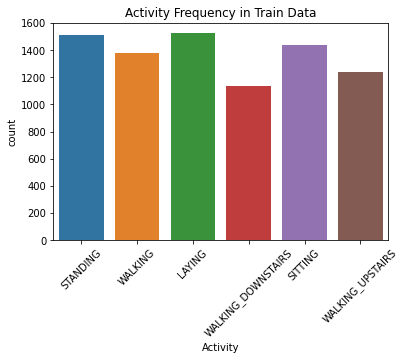

In [8]:
#Plot activity freq
plt.title("Activity Frequency in Train Data")
sns.countplot(x=y.Activity)
plt.xticks(rotation=45)
plt.show()

We observe that the all activities have comparable frequencies

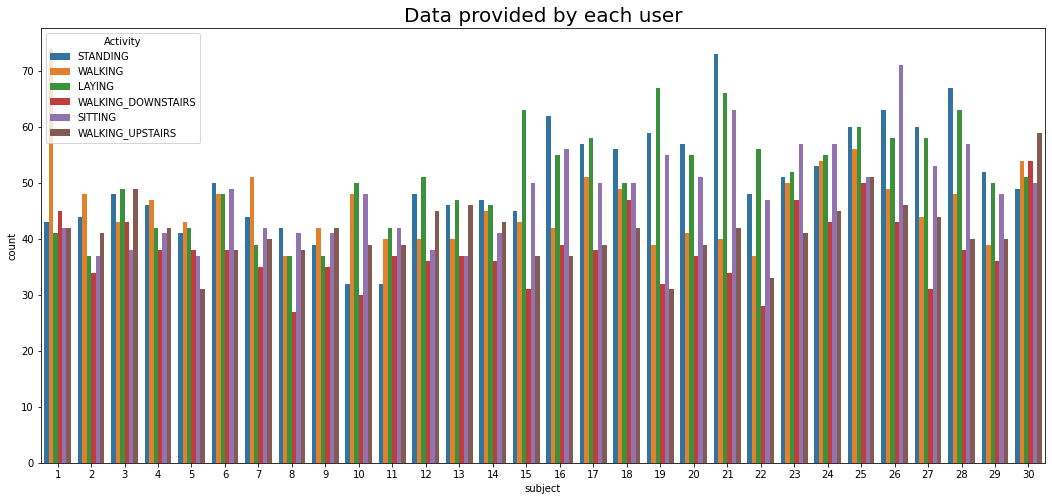

In [9]:
#Distribution of different types of activity data provided by each subject
plt.figure(figsize=(18,8))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x=X.subject, hue=y.Activity)
plt.show()

We can see that the readings are pretty uniform across all 30 subjects

In [10]:
Acc=0
Gyro=0
other=0
for i in X.columns:
  if'Acc'in i:
    Acc=Acc+1
  elif'Gyro'in i:
    Gyro=Gyro+1
  else:
    other=other+1

px.bar(x=['Accelerometer ','Gyroscope ','other'],y=[Acc,Gyro,other],color=[Acc,Gyro,other])

This tells us that there is more data acquired from the Accelerometer as compared to Gyroscope and other sensors.
This accelerometer information should potentially be more significant in the case of dynamic activities such as walking and walking upstairs/downstairs. 

In [7]:
#Renaming feature names by removing punctuations
columns = X.columns

# Removing '()' from column names
columns = columns.str.replace('[()]','',regex=True)
columns = columns.str.replace('[-]', '',regex=True)
columns = columns.str.replace('[,]','',regex=True)

X.columns = columns
X.columns = columns

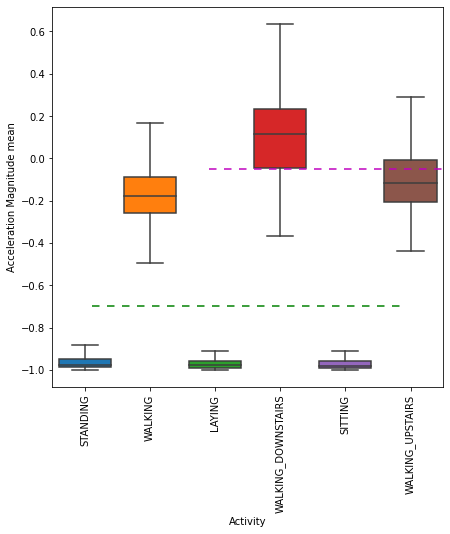

In [12]:
plt.figure(figsize=(7,7))
sns.boxplot(x=y.Activity, y=X.tBodyAccMagmean, showfliers=False, saturation=1)
plt.ylabel('Acceleration Magnitude mean')
plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
plt.xticks(rotation=90)
plt.show()

**Observations**


*   If tAccMean is < -0.8 then the Activities are either Standing or Sitting or Laying.
*   If tAccMean is > -0.6 then the Activities are either Walking or WalkingDownstairs or WalkingUpstairs.
*   If tAccMean > 0.0 then the Activity is WalkingDownstairs.

As hypothesized, acceleration mean vaules can easily separate the static activities from the dynamic ones. Therefore, this feature seems to be pretty useful.





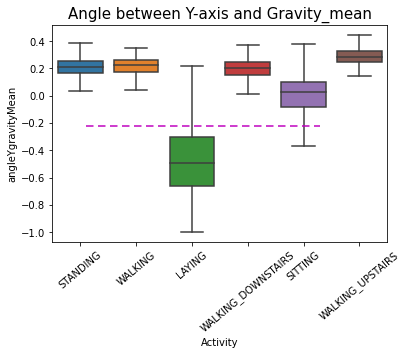

In [13]:
sns.boxplot(x=y.Activity, y=X.angleYgravityMean, showfliers=False)
plt.title('Angle between Y-axis and Gravity_mean', fontsize=15)
plt.xticks(rotation = 40)
plt.axhline(y=-0.22, xmin=0.1, xmax=0.8, dashes=(5,3), c='m')
plt.show()

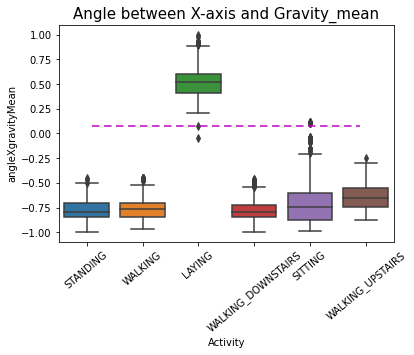

In [14]:
sns.boxplot(x=y.Activity, y=X.angleXgravityMean)
plt.axhline(y=0.08, xmin=0.1, xmax=0.9,c='m',dashes=(5,3))
plt.title('Angle between X-axis and Gravity_mean', fontsize=15)
plt.xticks(rotation = 40)
plt.show()

**Observations**


*   If angleX,gravityMean > 0 or angleY,gravityMean < 0.2 then Activity is Laying.
*   We can potentially classify all datapoints belonging to Laying activity with just a single if else statement.

Therefore, this is another feature that seems to be useful.


# One Hot Encoding
In training data, the subject column is categorical.<br/>
Our class labels are also categorical.

In [8]:
X["subject"]=X["subject"].apply(str)
X["subject"]=X["subject"].apply(str)

X=pd.get_dummies(X,columns=["subject"],drop_first=True)
X_submit=pd.get_dummies(X_submit,columns=["subject"],drop_first=True)

In [16]:
X.head()

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,...,subject_28,subject_29,subject_3,subject_30,subject_4,subject_5,subject_6,subject_7,subject_8,subject_9
356,0.286433,-0.023843,-0.122738,-0.915584,-0.710794,-0.880226,-0.932429,-0.720314,-0.881657,-0.789914,...,0,0,1,0,0,0,0,0,0,0
4482,0.333258,-0.001307,-0.166581,-0.034498,-0.062471,-0.283268,-0.059698,-0.174912,-0.338661,0.283234,...,0,0,0,0,0,0,0,0,0,0
10012,0.266797,-0.018683,-0.101142,-0.990874,-0.989001,-0.987255,-0.991659,-0.987859,-0.985430,-0.936624,...,0,0,0,0,0,0,0,0,0,0
4386,0.276363,-0.020289,-0.113701,-0.995733,-0.939094,-0.984418,-0.997013,-0.936180,-0.983728,-0.938433,...,0,0,0,0,0,0,0,0,0,0
3751,0.268231,-0.004146,-0.094503,0.473123,0.452403,-0.152600,0.450082,0.482764,-0.239383,0.539911,...,0,0,0,0,0,0,0,0,0,0


# Train-Test split

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y["Activity"], test_size=0.3, random_state=42)

# K-Neighbours Classification

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn_model=KNeighborsClassifier(n_jobs=-1)

n_neighbors=np.arange(1,26)
weights=['uniform', 'distance']
metric=["euclidean","manhattan","chebyshev","minkowski"]
p=np.arange(1,6)
param_grid_knn={"n_neighbors":n_neighbors,"weights":weights,"metric":metric,"p":p}

grid_model_knn=GridSearchCV(knn_model,param_grid=param_grid_knn,n_jobs=-1,verbose=3,scoring="accuracy",cv=3)

grid_model_knn.fit(X_train,y_train)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25]),
                         'p': array([1, 2, 3, 4, 5]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=3)

In [21]:
grid_model_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}

Accuracy =  0.9805825242718447

                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       457
           SITTING       0.96      0.94      0.95       455
          STANDING       0.94      0.96      0.95       465
           WALKING       1.00      1.00      1.00       389
WALKING_DOWNSTAIRS       1.00      1.00      1.00       331
  WALKING_UPSTAIRS       0.99      1.00      1.00       375

          accuracy                           0.98      2472
         macro avg       0.98      0.98      0.98      2472
      weighted avg       0.98      0.98      0.98      2472
 



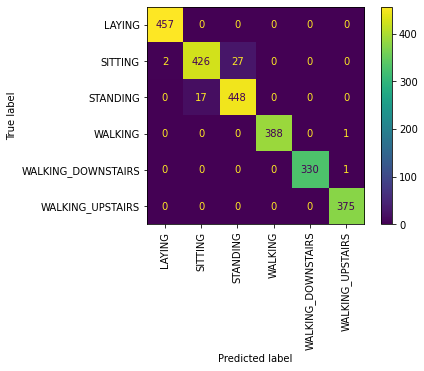

In [22]:
pred_knn=grid_model_knn.predict(X_test)

print("Accuracy = ", accuracy_score(y_test,pred_knn))
print("\n",classification_report(y_test,pred_knn),"\n")

ConfusionMatrixDisplay.from_predictions(y_test,pred_knn,xticks_rotation="vertical")
plt.show()

# Support Vector Machines

In [23]:
from sklearn.svm import SVC

svm_model=SVC(verbose=1,max_iter=-1)

c=np.linspace(0.0001,100,10)
kernel=["linear","poly","rbf","sigmoid"]
degree=[1,2,5,6,10]
gamma=["scale","auto"]
param_grid_svm={"C":c,"kernel":kernel,"degree":degree,"gamma":gamma}

grid_model_svm=GridSearchCV(svm_model,param_grid=param_grid_svm,n_jobs=-1,verbose=3,scoring="accuracy",cv=3)

grid_model_svm.fit(X_train,y_train)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
[LibSVM]

GridSearchCV(cv=3, estimator=SVC(verbose=1), n_jobs=-1,
             param_grid={'C': array([1.00000e-04, 1.11112e+01, 2.22223e+01, 3.33334e+01, 4.44445e+01,
       5.55556e+01, 6.66667e+01, 7.77778e+01, 8.88889e+01, 1.00000e+02]),
                         'degree': [1, 2, 5, 6, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=3)

In [24]:
grid_model_svm.best_params_

{'C': 33.333400000000005, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Accuracy =  0.9923139158576052

                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       457
           SITTING       0.98      0.97      0.98       455
          STANDING       0.97      0.98      0.98       465
           WALKING       1.00      1.00      1.00       389
WALKING_DOWNSTAIRS       1.00      1.00      1.00       331
  WALKING_UPSTAIRS       1.00      1.00      1.00       375

          accuracy                           0.99      2472
         macro avg       0.99      0.99      0.99      2472
      weighted avg       0.99      0.99      0.99      2472
 



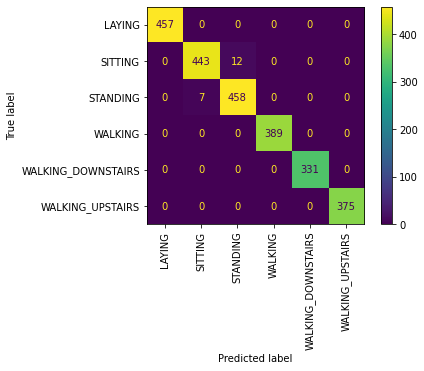

In [25]:
pred_svm=grid_model_svm.predict(X_test)

print("Accuracy = ", accuracy_score(y_test,pred_svm))
print("\n",classification_report(y_test,pred_svm),"\n")

ConfusionMatrixDisplay.from_predictions(y_test,pred_svm,xticks_rotation="vertical")
plt.show()

# Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

dt_model=DecisionTreeClassifier(splitter="best",max_features="none")

criterion=["gini","entropy"]
max_depth= list(range(1,15)) + [None]
min_samples_split=np.arange(2,22,2)
max_features=["sqrt","log2",None]
min_impurity_decrease=np.arange(0,0.7,0.1)
param_grid_dt={"criterion":criterion,"max_depth":max_depth,"min_samples_split":min_samples_split,"max_features":max_features,"min_impurity_decrease":min_impurity_decrease}

grid_model_dt=GridSearchCV(dt_model,param_grid=param_grid_dt,n_jobs=-1,verbose=3,scoring="accuracy",cv=3)

grid_model_dt.fit(X_train,y_train)


Fitting 3 folds for each of 6300 candidates, totalling 18900 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(max_features='none'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_impurity_decrease': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])},
             scoring='accuracy', verbose=3)

In [27]:
grid_model_dt.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'min_impurity_decrease': 0.0,
 'min_samples_split': 2}

Accuracy =  0.9348705501618123

                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       457
           SITTING       0.91      0.90      0.91       455
          STANDING       0.91      0.92      0.91       465
           WALKING       0.94      0.95      0.95       389
WALKING_DOWNSTAIRS       0.92      0.92      0.92       331
  WALKING_UPSTAIRS       0.93      0.92      0.93       375

          accuracy                           0.93      2472
         macro avg       0.93      0.93      0.93      2472
      weighted avg       0.93      0.93      0.93      2472
 



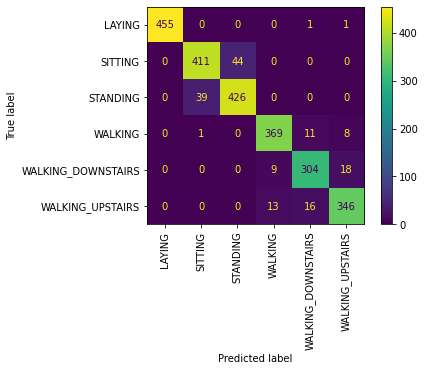

In [28]:
pred_dt=grid_model_dt.predict(X_test)

print("Accuracy = ", accuracy_score(y_test,pred_dt))
print("\n",classification_report(y_test,pred_dt),"\n")

ConfusionMatrixDisplay.from_predictions(y_test,pred_dt,xticks_rotation="vertical")
plt.show()

# Random Forests

In [8]:
from sklearn.ensemble import RandomForestClassifier

rfc_model=RandomForestClassifier(n_jobs=-1,random_state=42)

n_estimators=[n**2 for n in range(8,13)]
criterion=["gini","entropy"]
max_depth= list(range(1,10)) + [None]
max_features=["sqrt","log2",None]
bootstrap=[True,False]
min_impurity_decrease=np.arange(0,0.7,0.1)
param_grid_rfc={"n_estimators":n_estimators,"criterion":criterion,"max_depth":max_depth,"max_features":max_features,"bootstrap":bootstrap,"min_impurity_decrease":min_impurity_decrease}

grid_model_rfc=GridSearchCV(rfc_model,param_grid=param_grid_rfc,n_jobs=-1,verbose=3,scoring="accuracy",cv=3)

grid_model_rfc.fit(X_train,y_train)

Fitting 3 folds for each of 4200 candidates, totalling 12600 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_impurity_decrease': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
                         'n_estimators': [64, 81, 100, 121, 144]},
             scoring='accuracy', verbose=3)

In [9]:
grid_model_rfc.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_impurity_decrease': 0.0,
 'n_estimators': 144}

Accuracy =  0.9834142394822006

                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       457
           SITTING       0.98      0.96      0.97       455
          STANDING       0.97      0.98      0.97       465
           WALKING       1.00      0.98      0.99       389
WALKING_DOWNSTAIRS       0.97      0.99      0.98       331
  WALKING_UPSTAIRS       0.98      0.99      0.99       375

          accuracy                           0.98      2472
         macro avg       0.98      0.98      0.98      2472
      weighted avg       0.98      0.98      0.98      2472
 



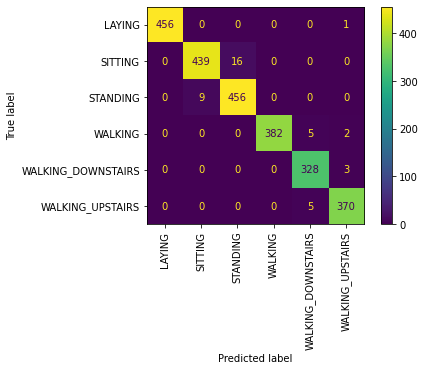

In [10]:
pred_rfc=grid_model_rfc.predict(X_test)

print("Accuracy = ", accuracy_score(y_test,pred_rfc))
print("\n",classification_report(y_test,pred_rfc),"\n")

ConfusionMatrixDisplay.from_predictions(y_test,pred_rfc,xticks_rotation="vertical")
plt.show()

# AdaBoost

In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adb_model=AdaBoostClassifier(random_state=42)

base_estimator=[DecisionTreeClassifier(max_depth=i) for i in range(1,6)]
n_estimators=np.arange(20,80,10)
param_grid_adb={"base_estimator":base_estimator,"n_estimators":n_estimators}

grid_model_adb=GridSearchCV(adb_model,param_grid=param_grid_adb,n_jobs=-1,verbose=3,scoring="accuracy",cv=3)

grid_model_adb.fit(X_train,y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeClassifier(max_depth=1),
                                            DecisionTreeClassifier(max_depth=2),
                                            DecisionTreeClassifier(max_depth=3),
                                            DecisionTreeClassifier(max_depth=4),
                                            DecisionTreeClassifier(max_depth=5)],
                         'n_estimators': array([20, 30, 40, 50, 60, 70])},
             scoring='accuracy', verbose=3)

In [12]:
grid_model_adb.best_params_

{'base_estimator': DecisionTreeClassifier(max_depth=5), 'n_estimators': 70}

Accuracy =  0.9644012944983819

                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       457
           SITTING       0.91      0.92      0.92       455
          STANDING       0.92      0.91      0.92       465
           WALKING       1.00      0.98      0.99       389
WALKING_DOWNSTAIRS       0.98      0.99      0.99       331
  WALKING_UPSTAIRS       0.98      0.99      0.99       375

          accuracy                           0.96      2472
         macro avg       0.97      0.97      0.97      2472
      weighted avg       0.96      0.96      0.96      2472
 



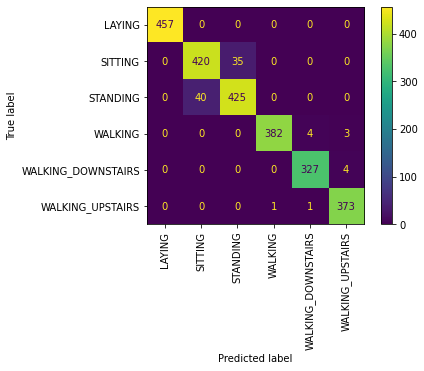

In [13]:
pred_adb=grid_model_adb.predict(X_test)

print("Accuracy = ", accuracy_score(y_test,pred_adb))
print("\n",classification_report(y_test,pred_adb),"\n")

ConfusionMatrixDisplay.from_predictions(y_test,pred_adb,xticks_rotation="vertical")
plt.show()

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model=LogisticRegression(solver="saga",multi_class="ovr",max_iter=10000,n_jobs=-1,verbose=1)

penalty=["none","elasticnet"]
l1_ratio=np.linspace(0,1,5)
c=np.linspace(0.0001,50,5)
param_grid_lr={"penalty":penalty,"l1_ratio":l1_ratio,"C":c}

grid_model_lr=GridSearchCV(lr_model,param_grid=param_grid_lr,n_jobs=-1,verbose=3,scoring="accuracy",cv=3)

grid_model_lr.fit(X_train,y_train)

In [ ]:
grid_model_lr.best_params_

In [ ]:
pred_lr=grid_model_lr.predict(X_test)

print("Accuracy = ", accuracy_score(y_test,pred_lr))
print("\n",classification_report(y_test,pred_lr),"\n")

ConfusionMatrixDisplay.from_predictions(y_test,pred_lr,xticks_rotation="vertical")
plt.show()

# Dimensionality Reduction

## Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC

best_model=SVC(C=33.333400000000005, degree=1, verbose=0)
accuracy=[]

for i in range(1,591,5):
    pca_model=PCA(n_components=i)
    X_train_new=pca_model.fit_transform(X_train)
    X_test_new=pca_model.transform(X_test)
    pred_new=best_model.fit(X_train_new,y_train).predict(X_test_new)
    accuracy.append(accuracy_score(y_test,pred_new))

print(f"Best Accuracy = {max(accuracy)} at n_components = {np.argmax(accuracy)+1}")

pca_model=PCA(n_components=(np.argmax(accuracy)+1))
X_train_pca=pca_model.fit_transform(X_train)
X_test_pca=pca_model.transform(X_test)
pred_pca=best_model.fit(X_train_pca,y_train).predict(X_test_pca)

print("\n",classification_report(y_test,pred_pca),"\n")
ConfusionMatrixDisplay.from_predictions(y_test,pred_pca,xticks_rotation="vertical")
plt.show()

## Linear Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

best_model=SVC(C=33.333400000000005, degree=1, verbose=0)
accuracy=[]

for i in range(1,6):
    lda_model=LinearDiscriminantAnalysis(solver="svd",n_components=i)
    X_train_new=lda_model.fit_transform(X_train,y_train)
    X_test_new=lda_model.transform(X_test)
    accuracy.append(accuracy_score(y_test,best_model.fit(X_train_new,y_train).predict(X_test_new)))

print(f"Best Accuracy = {max(accuracy)} at n_components = {np.argmax(accuracy)+1}")

lda_model=PCA(n_components=(np.argmax(accuracy)+1))
X_train_lda=lda_model.fit_transform(X_train)
X_test_lda=lda_model.transform(X_test)
pred_lda=best_model.fit(X_train_lda,y_train).predict(X_test_lda)

print("\n",classification_report(y_test,pred_lda),"\n")
ConfusionMatrixDisplay.from_predictions(y_test,pred_lda,xticks_rotation="vertical")
plt.show()

# Feature Selection

## Pearson Correlation

In [ ]:
from sklearn.feature_selection import SelectKBest, r_regression

def pearsoncorr_test(no_features):
  selector=SelectKBest(r_regression,k=no_features)
  col_num=selector.fit(X_train,y_train.replace(['STANDING', 'WALKING', 'LAYING', 'WALKING_DOWNSTAIRS', 'SITTING','WALKING_UPSTAIRS'],[1,2,3,4,5,6])).get_support(indices=True)
  return X_train.columns[col_num]

## Anova Test

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

def anova_test(no_features):
  selector=SelectKBest(f_classif,k=no_features)
  col_num=selector.fit(X_train,y_train.replace(['STANDING', 'WALKING', 'LAYING', 'WALKING_DOWNSTAIRS', 'SITTING','WALKING_UPSTAIRS'],[1,2,3,4,5,6])).get_support(indices=True)
  return X_train.columns[col_num]